<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Age             48842 non-null  int64
 1   Workclass       48842 non-null  int32
 2   fnlwgt          48842 non-null  int64
 3   Education       48842 non-null  int32
 4   Education_num   48842 non-null  int64
 5   Marital_Status  48842 non-null  int32
 6   Occupation      48842 non-null  int32
 7   Relationship    48842 non-null  int32
 8   Race            48842 non-null  int32
 9   Capital_gain    48842 non-null  int64
 10  Capital_loss    48842 non-null  int64
 11  Hours_per_week  48842 non-null  int64
 12  Native_country  48842 non-null  int32
 13  Income          48842 non-null  int32
dtypes: int32(8), int64(6)
memory usage: 3.7 MB
              precision    recall  f1-score   support

           0       0.20      0.00      0.00      1233
           1       0.87      1.00      0.93   

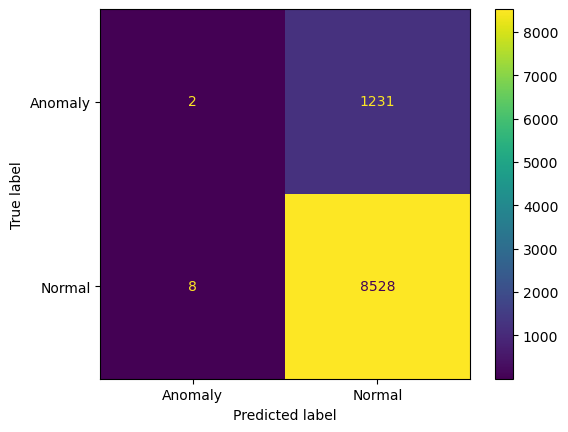

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

def hybrid_anomaly_detection():
    
    data = pd.read_csv('adultdata.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    data = data.drop('Sex', axis=1)
    
    X = data.drop('fnlwgt', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['fnlwgt']
    
    y = np.where(y_cont > 80000, 1, 0)  # Define `threshold` based on your domain knowledge
    
    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    data.info()


    data.dropna(axis=0, inplace=True)
    
    
    
    
    
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    
    # Phase 1: Train Isolation Forest on the training data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train)
    # Predict on the training data to filter for normal data only
    train_preds = iso_forest.predict(X_train)

    # Filter normal data as input for the SVM
    X_train_filtered = X_train[train_preds == 1]
    y_train_filtered = y_train[train_preds == 1]

    # Phase 2: Train SVM on the filtered normal data
    svm = SVC(kernel='rbf', gamma='auto', random_state=42)
    svm.fit(X_train_filtered, y_train_filtered)

    # Evaluate on the original full test dataset
    svm_predictions = svm.predict(X_test)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, svm_predictions, pos_label=0)
    recall = recall_score(y_test, svm_predictions, pos_label=0)
    f1 = f1_score(y_test, svm_predictions, pos_label=0)

    # Print metrics
    
    print(classification_report(y_test, svm_predictions))
    
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, svm_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Assuming X and y are your dataset's features and labels respectively
hybrid_anomaly_detection()
